In [2]:
import numpy as np, pandas as pd, torch, os, glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
#pickle loading
# merge experiment
USD_data_train_pkl = glob.glob("./dataset/PeriHD_pickle_save/USD_sample2693_only-merge-sequence_contextsplit/train/*_fixed_re-marked_merge.pkl")
USD_data_valid_pkl = glob.glob("./dataset/PeriHD_pickle_save/USD_sample2693_only-merge-sequence_contextsplit/valid/*_fixed_re-marked_merge.pkl")

In [4]:
def pk2pf(pkl_list):
    data_train = []
    for pk in pkl_list:
        with open(pk, 'rb') as f:
            pk_dict = pickle.load(f)
        data_train.append(pk_dict)
    data_train = pd.DataFrame(data_train)
    
    return data_train
USD_data_train = pk2pf(USD_data_train_pkl)
USD_data_valid = pk2pf(USD_data_valid_pkl)

In [5]:
print(len(USD_data_train.label.values)-sum(USD_data_train.label.values), sum(USD_data_train.label.values))
print(len(USD_data_valid.label.values)-sum(USD_data_valid.label.values), sum(USD_data_valid.label.values))

4638 1229
759 194


In [6]:
# print(len(USD_data_train.label.values)-sum(USD_data_train.label.values), sum(USD_data_train.label.values))
# print(len(USD_data_valid.label.values)-sum(USD_data_valid.label.values), sum(USD_data_valid.label.values))

In [7]:
# ### USD model embedding
USD_training_embeddings = np.array(USD_data_train.embed.tolist())
USD_validation_embeddings = np.array(USD_data_valid.embed.tolist())
print("Internal train", USD_training_embeddings.shape)
print("Internal test" ,USD_validation_embeddings.shape)

Internal train (5867, 512)
Internal test (953, 512)


In [8]:
import keras
def create_model(input_shape = (512,)):
  model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  # model.compile(loss=FocalTverskyLoss, 
  #             optimizer='adam',
  #             metrics=['acc'])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
  return model

2023-04-04 08:28:34.875882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 08:28:35.135363: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 08:28:35.739529: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-04 08:28:35.739636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

 63/184 [=========>....................] - ETA: 0s

2023-04-04 08:29:17.060176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 0s 1ms/step


Text(0.5, 1.0, '[Internal][USD]PeriHD Test ROC-Curve')

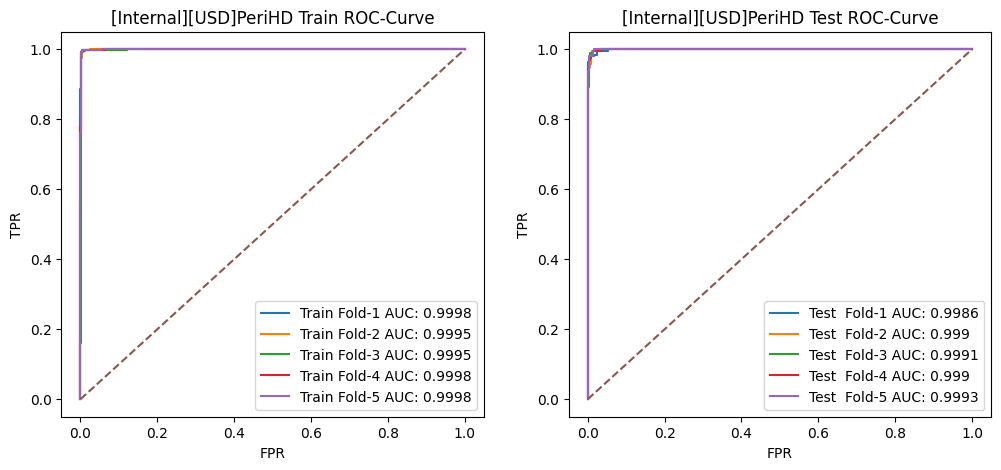

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
def get_weight_path(fold, train_type):
    return "./model_weight/PeriHD/weights_periHD_KFold={}[{}-only-merge-sequnece-resplit].h5".format(fold,train_type)
    # return "./demo_weight/weights_periHD_KFold={}[{}]-base.h5".format(fold,train_type)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
history_stack = []
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
CM_train = []
CM_test = []
eval = True
train_type = 'USD'
fold_no = 1
if train_type=="USD":
    in_shape = 512
    training_embedding_ = USD_training_embeddings
    validation_embedding = USD_validation_embeddings
    data_train = USD_data_train
    data_valid = USD_data_valid
train_binary_pred_and_score = []
test_binary_pred_and_score = [ ]
for train, test in kfold.split(training_embedding_, data_train['label'].values.tolist()):
    weight_name = get_weight_path(fold_no, train_type)
    cls_model = create_model(input_shape=(in_shape,))
    if eval==False:
        callbacks = [
            EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
                monitor='val_loss',
                min_delta=1e-4,
                patience=10,
                verbose=0
            ),
            ModelCheckpoint(
                filepath=weight_name,
                monitor='val_loss', 
                mode='min', 
                save_best_only=True,
                save_weights_only=True,
                verbose=0
            )
        ]
        history = cls_model.fit(training_embedding_[train], 
                data_train['label'].values[train], 
                batch_size=64, 
                validation_data=(training_embedding_[test], data_train['label'].values[test]), 
                epochs=300, 
                callbacks=callbacks,verbose=0)
        history_stack.append(history)

    elif eval==True:
        cls_model.load_weights(weight_name)
    train_pred = cls_model.predict(training_embedding_)
    test_pred = cls_model.predict(validation_embedding)
    # binary_pred = np.argmax(pred, axis=1)
    train_binary_pred = (train_pred>0.5).astype(np.int8)
    test_binary_pred = (test_pred>0.5).astype(np.int8)
    train_binary_pred_and_score.append([train_pred, train_binary_pred])
    test_binary_pred_and_score.append([test_pred, test_binary_pred])
    
    tn, fp, fn, tp = confusion_matrix(data_train['label'].values, train_binary_pred).ravel()
    # CM_train.append([tn, fp, fn, tp])
    CM_train.append([data_train['label'].values, train_binary_pred])
    tn, fp, fn, tp = confusion_matrix(data_valid['label'].values, test_binary_pred).ravel()
    # CM_test.append([tn, fp, fn, tp])
    CM_test.append([data_valid['label'].values, test_binary_pred])
    
    fpr, tpr, thresholds = roc_curve(data_train['label'].values, train_pred, pos_label=1)
    auc = roc_auc_score(data_train['label'].values, train_pred)
    axs[0].plot(fpr, tpr, label = "Train Fold-{} AUC: {}".format(fold_no, round(auc, 4)))

    fpr, tpr, thresholds = roc_curve(data_valid['label'].values, test_pred, pos_label=1)
    auc = roc_auc_score(data_valid['label'].values, test_pred)
    axs[1].plot(fpr, tpr, label = "Test  Fold-{} AUC: {}".format(fold_no, round(auc, 4)))
    fold_no=fold_no+1

axs[0].plot([0,1],[0,1], linestyle='--')
axs[1].plot([0,1],[0,1], linestyle='--')

axs[0].legend()
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].set_title(f"[Internal][{train_type}]PeriHD Train ROC-Curve")
axs[1].legend()
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")
axs[1].set_title(f"[Internal][{train_type}]PeriHD Test ROC-Curve")

In [11]:
# history_stack[0].history

In [12]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
# 已標記資料效能評估
def metric_calc(array_):
    y_test, y_pred = array_
    report = classification_report(y_test, y_pred, output_dict=True)
    # macro_f1 = report['macro avg']['f1-score']
    # weighted_f1 = report['weighted avg']['f1-score']
    # macro_precision = report['macro avg']['precision']
    # weighted_precision = report['weighted avg']['precision']
    # macro_recall = report['macro avg']['recall']
    # weighted_recall = report['weighted avg']['recall']
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    sens = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn/(tn+fp)
    return acc, prec, sens, spec, f1

def get_metric(arr):
    mean_arr = np.mean(np.array(arr), axis=0)
    std_arr = np.std(np.array(arr), axis=0)
    return mean_arr, std_arr

In [13]:

# CM_train = np.array(CM_train)
# CM_test = np.array(CM_test)
T_stack, t_stack = [],[]
for T_ in CM_train:
    T_stack.append(metric_calc(T_))
    
for t_ in CM_test:
    t_stack.append(metric_calc(t_))
#內部資料 - Train & Test
mark_train_mean, mark_train_std = get_metric(T_stack)
mark_test_mean, mark_test_std = get_metric(t_stack)
mark_train = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Train'])
for T_, f in zip(T_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_train[f] = np.round(T_,4)
mark_train['Mean'] = np.round(mark_train_mean,4)
mark_train['Std'] = np.round(mark_train_std,4)

mark_test = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Test'])
for t_, f in zip(t_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_test[f] = np.round(t_,4)
mark_test['Mean'] = np.round(mark_test_mean,4)
mark_test['Std'] = np.round(mark_test_std,4)

In [14]:
temp = {'Train&Valid斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for fold_result in train_binary_pred_and_score:
    train_pred_singel = fold_result[0].flatten()
    train_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),train_binary_pred_singel, train_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

for fold_result in test_binary_pred_and_score:
    test_pred_singel = fold_result[0].flatten()
    test_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),test_binary_pred_singel, test_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

failed_pf = pd.DataFrame(temp, columns=['Train&Valid斷句','真實答案','預測答案','預測分數'])

In [15]:
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 20)
# failed_pf = failed_pf.drop_duplicates(subset='Train&Valid斷句')
# failed_pf.to_csv("./total_fold_faild_predict.csv", index=False, encoding='utf-8-sig')


In [16]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 20)
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),train_binary_pred.flatten(), train_pred.flatten()):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
train_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數'])

In [17]:
# train_failed_pf

In [18]:
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for i in zip(USD_data_valid['text'].tolist(), USD_data_valid['label'].tolist(),test_binary_pred.flatten(), test_pred.flatten()):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
test_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數'])

In [19]:
test_failed_pf

,斷句,真實答案,預測答案,預測分數
0,予回血HOLD HD並ON EKG MONITOR，血壓131/71MMHG,1,0,0.382
1,RR36次/分，並請徐世平醫師診視,1,0,0.099
2,建議病人返家測量血壓若大於仍需服降壓藥,0,1,0.987
3,予回血HOLD HD並ON EKG MONITOR， 血壓131/71MMHG,1,0,0.446
4,現Dopamin 400mg+D5W250ml iv 4cc/hr，今由右側Perm cat...,1,0,0.262
5,RR36次/分， 並請徐世平醫師診視,1,0,0.102
6,不適，且有vomiting情形,1,0,0.140
7,前來探視病人，開立VENA 1 AMP IV ST 囑打完藥後再回病房,1,0,0.055
8,開立VENA 1 AMP IV ST 囑打完藥後再回病房，AT 19:40血壓211/78m...,1,0,0.368
9,予N/S Challenge 500ml iv stat，D50W 1amp IV stat,1,0,0.375


In [26]:
pd.concat([train_failed_pf, test_failed_pf]).to_csv("./failed_predict_sentence_train&test.csv", encoding='utf-8-sig', index=False)

In [18]:
mark_train

,USD Metric Train,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9910,0.9896,0.9879,0.9882,0.9874,0.9888,0.0013
1,Precision [macro],0.9870,0.9879,0.9866,0.9880,0.9821,0.9863,0.0022
2,Sensitivity [macro],0.9909,0.9864,0.9834,0.9827,0.9871,0.9861,0.0029
3,Specificity,0.9912,0.9937,0.9937,0.9953,0.9879,0.9924,0.0026
4,F1-score [macro],0.9889,0.9871,0.9850,0.9853,0.9845,0.9862,0.0016


In [19]:
mark_test

,USD Metric Test,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9676,0.9714,0.9666,0.9666,0.9657,0.9676,0.0020
1,Precision [macro],0.9613,0.9724,0.9679,0.9690,0.9618,0.9665,0.0043
2,Sensitivity [macro],0.9574,0.9557,0.9482,0.9471,0.9518,0.9520,0.0040
3,Specificity,0.9802,0.9908,0.9895,0.9908,0.9829,0.9868,0.0044
4,F1-score [macro],0.9593,0.9636,0.9574,0.9573,0.9566,0.9589,0.0025


In [20]:
mark_train

,USD Metric Train,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9910,0.9896,0.9879,0.9882,0.9874,0.9888,0.0013
1,Precision [macro],0.9870,0.9879,0.9866,0.9880,0.9821,0.9863,0.0022
2,Sensitivity [macro],0.9909,0.9864,0.9834,0.9827,0.9871,0.9861,0.0029
3,Specificity,0.9912,0.9937,0.9937,0.9953,0.9879,0.9924,0.0026
4,F1-score [macro],0.9889,0.9871,0.9850,0.9853,0.9845,0.9862,0.0016
